In [72]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

solver = pyo.SolverFactory('glpk')

In [107]:
def plot_results(P01M, P02M, P1,P2, b01, b02, model):
    coef = 2
    nb = 20
    vec_range = [coef * i / nb for i in range(nb+1)]

    plt.plot([p1*P01M for p1 in vec_range], [P02M for i in range(nb+1)], color = 'red')
    plt.plot([P01M for i in range(nb+1)], [p2*P02M for p2 in vec_range], color = 'red')
    plt.plot([p1 * P01M for p1 in vec_range], [(1+b02/b01) * P01M - p1 * P01M for p1 in vec_range], color = 'blue')
    plt.plot([p1 * P01M for p1 in vec_range], [(1+b01/b02) * P02M - p1 * P01M for p1 in vec_range], color = 'blue')
    plt.plot(P1, P2, 'x')
    plt.plot(P1 - model.ls1.value, P2 - model.ls2.value, 'o', color = 'red' if model.br.value == 0 else 'green')
    plt.xlim(0, P01M * coef)
    plt.ylim(0, P02M * coef)
    plt.show()

In [118]:
P01M = 1.5
P02M = 1
P1 = 1.7
P2 = 0.4
b01 = .75
b02 = 1



Problem: 
- Name: unknown
  Lower bound: 0.2
  Upper bound: 0.2
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 10
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 3
      Number of created subproblems: 3
  Error rc: 0
  Time: 0.01598811149597168
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

3 Var Declarations
    br : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.0 :     1 : False : False : Binary
    ls1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.2 :   1.7 : False : False : NonNegativeReals
    ls2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.0 :   0.4 : False : False : NonNegativeReals

1 Objective Declarations
    ob

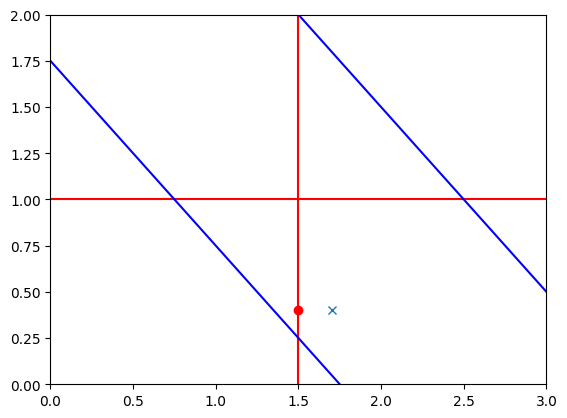

In [119]:
bM = 1e3

model = pyo.ConcreteModel()
model.ls1 = pyo.Var(bounds = (0, P1), domain = pyo.NonNegativeReals)
model.ls2 = pyo.Var(bounds = (0, P2), domain = pyo.NonNegativeReals)
model.br = pyo.Var(domain = pyo.Binary)

def constr_br_open(p, ls, br, bM, p_max):
    return p - ls - br * bM <= p_max

def constr_br_close(p1, p2, ls1, ls2, b01, b02, br, bM, p_max):
    return b01 / (b01 + b02) * (p1 + p2 - ls1 - ls2) - (1 - br) * bM <= p_max

model.const_open1 = pyo.Constraint(rule = constr_br_open(P1, model.ls1, model.br, bM, P01M))
model.const_open2 = pyo.Constraint(rule = constr_br_open(P2, model.ls2, model.br, bM, P02M))
model.const_close1 = pyo.Constraint(rule = constr_br_close(P1, P2, model.ls1, model.ls2, b01, b02, model.br, bM, P01M))
model.const_close2 = pyo.Constraint(rule = constr_br_close(P1, P2, model.ls1, model.ls2, b02, b01, model.br, bM, P02M))

model.obj = pyo.Objective(rule = model.ls1 + model.ls2 - model.br / 10000, sense = pyo.minimize) # - model.br['br'] / bM
# solver.solve(model)
print(solver.solve(model))
model.pprint()
plot_results(P01M, P02M, P1,P2, b01, b02, model)